# Приоритизация и проверка гипотез по увеличению выручки интернет-магазина

## Описание проекта

**Цель проекта** 

Совместно с отделом маркетинга был подготовлен список гипотез для увеличения выручки интернет-магазина. Задача - приоритизировать гипотезы, а также проанализировать результаты А/В теста.

**Описание данных**

**hypothesis.csv**
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

**orders.csv**
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

**visitors.csv**
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

## Подготовка данных

In [1]:
#импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

In [2]:
#чтение датасетов
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', parse_dates=['date'])
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', parse_dates=['date'])

#запоминаем предустановленную длину строки и сбрасываем это ограничение
preset_colwidth = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', None)

display(hypothesis)
display(orders.head())
display(visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Сразу преобразуем названия колонок в таблицах **hypotesis** и **orders** к snake_case:

In [3]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [4]:
orders = orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'})
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

# Часть 1. Приоритизация гипотез

Посмотрим на параметры гипотез:

In [5]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Применим фреймворки **ICE** и **RICE**:

\begin{equation}
\textbf{ICE} = \frac{Impact * Confidence}{Efforts}
\end{equation}

\begin{equation}
\textbf{RICE} = \frac{Rearch * Impact * Confidence}{Efforts}
\end{equation}

In [6]:
hypothesis['ICE'] = round(
    (hypothesis['impact'] 
     * hypothesis['confidence']) 
    / hypothesis['efforts'], 2)

hypothesis['RICE'] = round(
    (hypothesis['reach'] 
     * hypothesis['impact'] 
     * hypothesis['confidence']) 
    / hypothesis['efforts'], 2)

display(hypothesis[['hypothesis', 'ICE']].sort_values(
    by='ICE', ascending=False).style.background_gradient(cmap ="coolwarm"))

display(hypothesis[['hypothesis', 'RICE']].sort_values(
    by='RICE', ascending=False).style.background_gradient(cmap ="coolwarm"))

#возвращаем предустановленную длину строки
pd.set_option('display.max_colwidth', preset_colwidth)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.330000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.330000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.120000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000


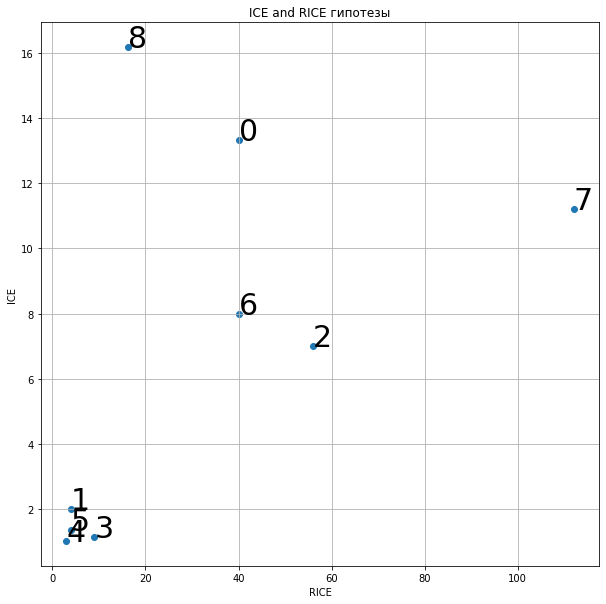

In [7]:
y = hypothesis['ICE'] 
z = hypothesis['RICE'] 
n = hypothesis.index 

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=30)

plt.title("ICE and RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE")
plt.grid()    

fig.set_figheight(10)
fig.set_figwidth(10) 
plt.show()    

Налучшие значения **ICE** у гипотез:

8 - Запустить акцию, дающую скидку на товар в день рождения
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

В то же время, с учётом оценки охвата аудитории, приоритет по **RICE** у гипотез:

7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию 

Таким образом, если выбирать гипотезу для проведения А/B теста, с учётом охвата аудитории в качестве приоритетной стоит рассмотреть гипотезу 7: **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**

# Часть 2. Анализ A/B-теста

## Предобработка данных

Проверим таблицы на соответствие типов данных и пустые значения.

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим таблицы на наличие явных дубликатов:

In [10]:
orders.duplicated().sum()

0

In [11]:
visitors.duplicated().sum()

0

Явных дубликатов не обнаружено. Проверим таблицу orders на уникальность ID покупок и ID пользователей: 

In [12]:
orders['transaction_id'].duplicated().sum()

0

In [13]:
orders['visitor_id'].duplicated().sum()

166

Неуникальность ID пользователей, скорее всего, связана с тем, что у каждого пользователя может быть несколько уникальных покупок. Выведем первые 10 строк таблицы orders для неуникальных пользователей, чтобы убедиться в этом.

In [14]:
visitors_id_duplicated = orders[orders['visitor_id'].duplicated()]['visitor_id'].unique()

orders.query('visitor_id in @visitors_id_duplicated').sort_values(by='visitor_id').head(10)

,transaction_id,visitor_id,date,revenue,group
71,3679129301,8300375,2019-08-01,10510,B
703,4293855558,8300375,2019-08-07,1790,A
1102,1941707234,199603092,2019-08-12,6438,A
823,2971973105,199603092,2019-08-27,2790,A
134,62794304,199603092,2019-08-22,6976,A
26,2223239646,199603092,2019-08-15,3488,A
246,437656952,199603092,2019-08-02,3488,B
1013,83566152,232979603,2019-08-31,60,A
1009,2670069237,232979603,2019-08-31,2640,B
1097,3357467820,237748145,2019-08-12,340,A


У каждого пользователя может быть несколько уникальных покупок. 

Видим, что в каждую покупку пользователь попадал либо в группу А, либо в группу B. Выясним, сколько пользователей попали и в группу А, и в группу B и их долю от общего числа пользователей:

In [15]:
visitors_ab_count = len(orders.groupby('visitor_id').agg({'group':'nunique'}).query('group > 1'))

print('Пользователи, попавшие в обе группы:', visitors_ab_count)
print('Доля от общего числа уникальных пользователей:', round(visitors_ab_count / len(orders['visitor_id'].unique()), 3))

Пользователи, попавшие в обе группы: 58
Доля от общего числа уникальных пользователей: 0.056


Таких пользователей 5.6%, однако удалить их нет возможности, полскольку таблица **visitors** содержит данные о пользователях уже в аккумулированном виде.

Проверим, какие группы в АВ-тесте в датафрейме **visitors**:

In [16]:
print('Группы в visitors:', visitors['group'].unique())

Группы в visitors: ['A' 'B']


Посмотрим, какие группы в датафрейме **orders** и сколько уникальных пользователей в каждой группе:

In [17]:
groups_users_num = orders.groupby('group').agg({'visitor_id':['nunique', 'count']})
groups_users_num.columns = ['buyers_unique', 'buyers_all']
groups_users_num = (groups_users_num.join(visitors.groupby('group').agg({'visitors':'sum'}))
                    .T.sort_values(by='A', ascending=False))
groups_users_num['A/B'] = round(groups_users_num['A'] / groups_users_num['B'], 2)
groups_users_num['Total'] = groups_users_num['A'] + groups_users_num['B']

display(groups_users_num)

group,A,B,A/B,Total
visitors,18736,18916,0.99,37652
buyers_all,557,640,0.87,1197
buyers_unique,503,586,0.86,1089


Группы A и B в равной степени распределены по посещениям, а среди уникальных покупаетелей соотношение сместилось: в группе B на 14% больше уникальных покупателей.

Выведем даты начала и окончания теста:

In [18]:
print('Дата первого посещения:', visitors['date'].dt.date.min())
print('Дата первой покупки:', orders['date'].dt.date.min())
print('Дата последнего посещения:', visitors['date'].dt.date.max())
print('Дата последней покупки:', orders['date'].dt.date.max())

Дата первого посещения: 2019-08-01
Дата первой покупки: 2019-08-01
Дата последнего посещения: 2019-08-31
Дата последней покупки: 2019-08-31


Тест проходил с 1 по 31 августа 2019г.

## Анализ результатов

### Кумулятивная выручка по группам

In [19]:
# массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates() 

orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max',
          'group' : 'max',
          'transaction_id' : 'nunique',
          'visitor_id' : 'nunique',
          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max',
          'group' : 'max',
          'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединение кумулятивных данных в одной таблице
cumulative_data = orders_aggregated.merge(visitors_aggregated,
                                          left_on=['date', 'group'],
                                          right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulative_data.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Проверим даты в датафрейме, совпадают ли они с исходными данными:

In [20]:
print('MIN:', cumulative_data['date'].dt.date.min())
print('MAX:', cumulative_data['date'].dt.date.max())

MIN: 2019-08-01
MAX: 2019-08-31


Даты совпадают, датафрейм создан корректно.

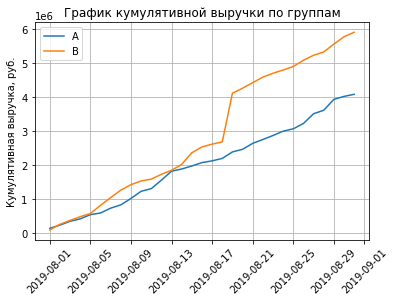

In [21]:
# кумулятивное количество заказов и выручки по дням, группа А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# кумулятивное количество заказов и выручки по дням, группа В
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# график выручки в группах А, B
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.xticks(rotation=45)
plt.legend() 
plt.ylabel('Кумулятивная выручка, руб.')
plt.grid(True)
plt.show()

Кумулятивная выручка в группе B с течением времени стала выше, чем в группе B, и резко увеличилась в точке с 17 по 20 августа, что может свидетельствовать либо о вспеске числа заказов, либо о наличии выбросов в выборке в виде дорогих заказов.

### Кумулятивный средний чек по группам

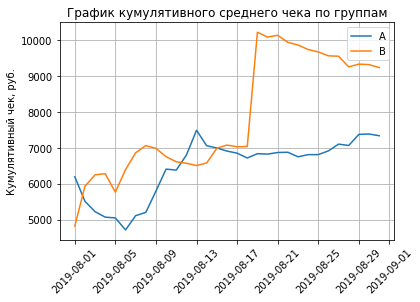

In [22]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.ylabel('Кумулятивный чек, руб.')
plt.grid(True)
plt.show()

Значеия кумулятивного среднего чека в группах стабилизиовались к середине августа, но в те же даты, что и скачок на предыдущем графике, видим резкое увеличение среднего чека в группе B. После этого скачка значения кумулятивного среднего чека в группе B снижаются, что опять говорит о необходимости исследовать данные на наличие выбросов.

Построим график относительного изменения кумулятивного среднего чека группы В к группе А:

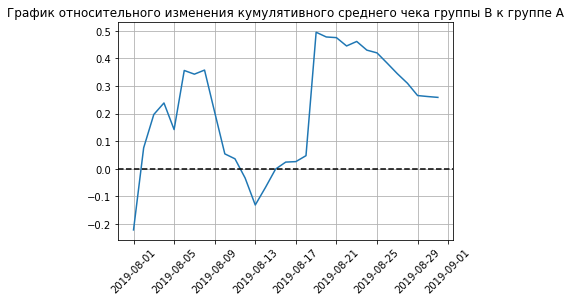

In [23]:
# объединяем таблицы групп
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b,
                                                       left_on='date',
                                                       right_on='date',
                                                       how='left',
                                                       suffixes=['A', 'B'])

# график отношения средних чеков
plt.plot(merged_cumulative_revenue['date'], \
         (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])\
         /(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)
plt.grid(True)
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

В нескольких точках график различия между сегментами резко изменяется, что, опять-таки, свидетельствует о выбросах.

### Кумулятивное среднее количество заказов по группам

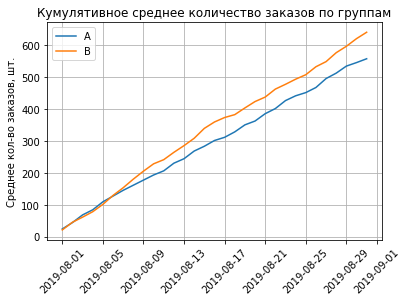

In [24]:
# данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.plot(cumulative_data_a['date'], cumulative_data_a['orders'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['orders'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel('Среднее кол-во заказов, шт.')
plt.title('Кумулятивное среднее количество заказов по группам')
plt.grid(True)
plt.show()

Кумулятивное среднее количество заказов в группе В росло медленнее группы А первые пять дней, затем группа В начала показывать лучшие результаты, к концу месяца опередив группу А на примерно 100 заказов

Построим график относительного изменения кумулятивного среднего количества заказов группы B к группе A:

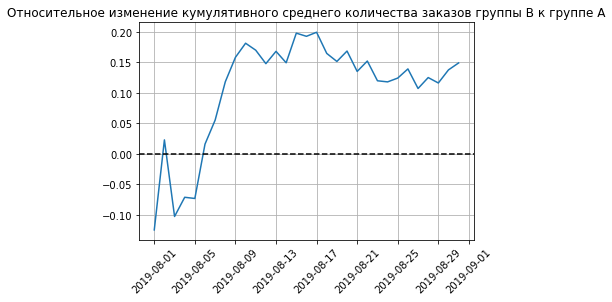

In [25]:
# объединение таблиц
merged_cumulative_data = cumulative_data_a.merge(cumulative_data_b,
                                                 left_on='date', 
                                                 right_on='date', 
                                                 how='left', 
                                                 suffixes=['A', 'B'])

# график отношения средних чеков
plt.plot(merged_cumulative_data['date'], (merged_cumulative_data['ordersB']/merged_cumulative_revenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Относительное изменение кумулятивного среднего количества заказов группы B к группе A')
plt.show()

В начале теста группа В уступала группе А, через неделю же начала показывать лучшие результаты и показывала их стабильно с незначительными перепадами до конца месяца.

### Определение границ аномальных значений

#### Количества заказов на пользователя

In [26]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

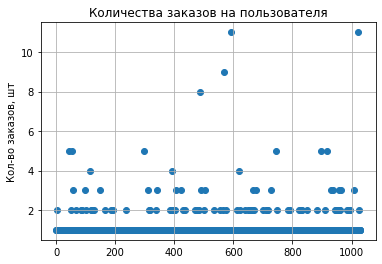

In [27]:
x_values = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values, orders_by_users['transaction_id']) 
plt.title('Количества заказов на пользователя')
plt.ylabel('Кол-во заказов, шт')
plt.grid(True)
plt.show()

In [28]:
np.percentile(orders_by_users['transaction_id'], [90, 95, 99])

array([1., 2., 4.])

5% пользователей оформляли больше 2х заказов, и 1% пользователей - больше 4 заказов. Для отсеивания аномальных значений выберем за верхнюю границу 4 заказа, по 99 percentile:

In [29]:
orders_percentile = np.percentile(orders_by_users['transaction_id'], [99])[0]

#### Cтоимость заказов

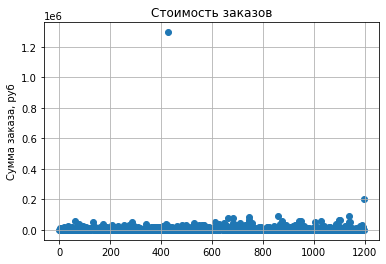

In [30]:
x_values = pd.Series(range(0,len(orders)))

plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.ylabel('Сумма заказа, руб')
plt.grid(True)
plt.show()

Видим два отчётливых выброса. Посмотрим, когда были эти заказы и к какой группе принадлежали:

In [31]:
orders.query('revenue > 200000')[['date','revenue','group']]

,date,revenue,group
425,2019-08-19,1294500,B
1196,2019-08-15,202740,B


Эти аномальные заказы по стоимости превышают остальные многократно, один из них - более чем в сто раз, причём оба заказа принадлежат к группе B и их даты совпадают по времени со скачком величины кумулятивного среднего чека в группе B.

Далее определим границы аномальных значений. Для наглядности построим тот же график со шкалой стоимости заказов до 100000.

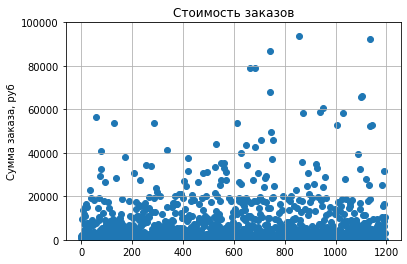

In [32]:
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.ylabel('Сумма заказа, руб')
plt.ylim(0,100000)
plt.grid(True)
plt.show()

In [33]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Определим границу для определения аномальных заказов в 58233.2руб., соответствующую 99% заказов:

In [34]:
revenue_percentile = np.percentile(orders['revenue'], [99])[0]

### Статистическая значимость между группами по "сырым" данным

#### Стат.значимость различий в среднем количестве заказов

Сравнивать будем среднее количество заказов на всех пользователей, включая тех, кто не сделал ни одного заказа.

Сформулируем гипотезы.

- Нулевая: различий в средем количестве заказов между группами А и В нет.
- Альлтернативная: различия в среднем количестве заказов между группами А и B есть.

Примем уровень статистической значимости: 0.05

Подготовим таблицы по группам с количеством посетителей и количеством заказов пользователей, сделавших хотя бы один заказ.

In [35]:
#Таблицы с посетителями по датам
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

#Таблицы с количестом заказов по посетитеям, сделавшим хотя бы один заказ
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']


orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

Сформируем таблицы по группам с количеством заказов всех посетителей, включая тех, кто не сделал ни одного заказа.

In [36]:
sample_a = pd.concat([orders_by_users_a['orders'],
                     pd.Series(0,
                               index=np.arange(visitors_a_daily['visitors_per_date_a'].sum()\
                                               - len(orders_by_users_a['orders'])),
                               name='orders')],
                    axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],
                     pd.Series(0,
                               index=np.arange(visitors_b_daily['visitors_per_date_b'].sum()\
                                               - len(orders_by_users_b['orders'])),
                               name='orders')],
                    axis=0)

Применим критерий Манна Уитни и выведем p-value, примем уровень статистической значимости также выведем относительный прирост среднего числа заказов группы B:

In [37]:
print("P-Value: {0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

if stats.mannwhitneyu(sample_a, sample_b)[1] <= 0.05:
    print('Есть основания отвергнуть нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
print("Относительный прирост среднего числа заказов группы B: {0:.3f}"
      .format(sample_b.mean() / sample_a.mean() - 1))

P-Value: 0.01679
Есть основания отвергнуть нулевую гипотезу
Относительный прирост среднего числа заказов группы B: 0.138


В соответствии с "сырыми" данными группа B получила относительный прирост числа заказов в 13.8%, при этом различия статистически значимы. 

Если результаты подтведятся на "чистых" данных, сможем сделать вывод о том, что проверяемая A/B тестом гипотеза подтвердилась.

#### Стат.значимость различий в среднем чеке заказа

Сформулируем гипотезы.

- Нулевая: различий в средем чеке заказов между группами А и В нет.
- Альлтернативная: различия в среднем чеке заказов между группами А и B есть.

Примем уровень статистической значимости: 0.05

In [38]:
sample_a = orders.query('group == "A"')['revenue']

sample_b = orders.query('group == "B"')['revenue']

In [39]:
print("P-Value: {0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

if stats.mannwhitneyu(sample_a, sample_b)[1] <= 0.05:
    print('Есть основания отвергнуть нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
print("Относительный прирост среднего чека в группе B: {0:.3f}"
      .format(sample_b.mean() / sample_a.mean() - 1))

P-Value: 0.72929
Нет оснований отвергнуть нулевую гипотезу
Относительный прирост среднего чека в группе B: 0.259


Прирост достаточно большой, 26%, однако значение P-Value по результатам применения критерия Манна-Уитни не даёт возможности утверждать, что различия статистически значимы. Далее увидим, изменятся ли результаты на "чистых" данных.

### Статистическая значимость между группами по "очищенным" данным

#### Стат.значимость различий в среднем количестве заказов

Сформулируем гипотезы.

- Нулевая: различий в средем количестве заказов между группами А и В нет.
- Альлтернативная: различия в среднем количестве заказов между группами А и B есть.

Примем уровень статистической значимости: 0.05

Подготовим данные по количеству заказов с учётом определённой ранее границы аномальных значений в 3 заказа.

In [40]:
sample_a = pd.concat([orders_by_users_a.query('orders <= @orders_percentile')['orders'],
                     pd.Series(0,
                               index=np.arange(visitors_a_daily['visitors_per_date_a'].sum()\
                                               - len(orders_by_users_a['orders'])),
                               name='orders')],
                    axis=0)

sample_b = pd.concat([orders_by_users_b.query('orders <= @orders_percentile')['orders'],
                     pd.Series(0,
                               index=np.arange(visitors_b_daily['visitors_per_date_b'].sum()\
                                               - len(orders_by_users_b['orders'])),
                               name='orders')],
                    axis=0)

In [41]:
print("P-Value: {0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

if stats.mannwhitneyu(sample_a, sample_b)[1] <= 0.05:
    print('Есть основания отвергнуть нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
print("Относительный прирост среднего числа заказов группы B: {0:.3f}"
      .format(sample_b.mean() / sample_a.mean() - 1))

P-Value: 0.01516
Есть основания отвергнуть нулевую гипотезу
Относительный прирост среднего числа заказов группы B: 0.154


В "очищенных" данных относительный прирост заказов группы B на процент выше, чем в "сырых", 15%, P-Value показывает сопоставимые с "сырыми" данными значения: 0.016 и 0.015, соответственно.

Таким образом, группа B показала лучшие и статистически значимые результаты по среднему количеству заказов, чем группа A, что следует как из "очищенных", так и из "сырых" данных.

#### Стат.значимость различий в среднем чеке заказа

Сформулируем гипотезы.

- Нулевая: различий в средем чеке заказов между группами А и В нет.
- Альлтернативная: различия в среднем чеке заказов между группами А и B есть.

Примем уровень статистической значимости: 0.05

Подготовим данные в сответстви с определённой ранее границей аномальных значений в 40000 руб..

In [42]:
sample_a = orders.query('group == "A" and revenue <= @revenue_percentile')['revenue']

sample_b = orders.query('group == "B" and revenue <= @revenue_percentile')['revenue']

In [43]:
print("P-Value: {0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

if stats.mannwhitneyu(sample_a, sample_b)[1] <= 0.05:
    print('Есть основания отвергнуть нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
print("Относительный прирост среднего чека в группе B: {0:.3f}"
      .format(sample_b.mean() / sample_a.mean() - 1))

P-Value: 0.62086
Нет оснований отвергнуть нулевую гипотезу
Относительный прирост среднего чека в группе B: 0.019


После избавления от аномальных данных относительный пирост среднего чека стал скромнее и составил 1.9%, при этом P-Value по-прежнему говорит о том, что различия не являются статистически значимыми.

### Выводы

1. Исходные данные свидетельствуют о том, что 5.6% пользователей, сделавших заказы, попали как в группу А, так и в группу B. Анализ A/B теста проведён с их учётом.


2. Выявлен ряд аномальных заказов, особенно выделились два заказа с суммами более 200 000руб. и более  1 200 000руб. Анализ статистической значимости был поизведён как с их учётом, так и без.


3. Выводы о различиях в среднем чеке в группе A и B:
- Относительный прирост среднего чека в группе B составил 26% в соответствии с исходными данными и 1.9% в соответствии с "очищенными" данными, ислючающими аномальные заказы;
- Как в исходных данных, так и в "очищенных" различия в среднем чеке не являются статистически значимыми;
- Поскольку в динамике средний чек в группе B к середине августа стабилизировался (если не принимать во внимание скачок, вызванный аномальными заазами) и далее показывает тенденцию к постепенному снижению, тест можно остановить и по результатам анализа зафиксировать осутствие статистически значимых различий между группами.

4. Выводы о различиях в среднем количестве заказов:
- Относительный прирост среднего числа заказов группы B составил 13.8% в соответствии с исходными данными и 15% по данным, исключающим аномальных пользователей, которые сделали более 4 заказов;
- Как в исходных данных, так и в "очищенных" различия в среднем количестве заказов являются статистически значимыми;
- Поскольку в динамике среднее количество заказов в группе B стабилизировалось и показывает стабильный прирост относительно группы A, тест можно остановить и в соответствии с наличием статистически значимых различий зафиксировать победу группы B.